# Supplementary Figure 3, Labeling UMAPs

In Supplementary Figure 3, we show UMAP projections for CD4 and CD8 cells before and after integration for cell type labeling

## Load packages

hise: The Human Immune System Explorer R SDK package  
purrr: Functional programming tools  
dplyr: Dataframe handling functions  
ggplot2: plotting functions  
ggrastr: raster plotting for ggplot2  
cowplot: multi-panel plot assembly  
Seurat: single-cell genomics methods

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(hise)
quiet_library(purrr)
quiet_library(dplyr)
quiet_library(ggplot2)
quiet_library(ggrastr)
quiet_library(cowplot)
quiet_library(Seurat)

In [2]:
out_dir <- "output/supp_figure_03"
if(!dir.exists(out_dir)) { dir.create(out_dir, recursive = TRUE) }

## Retrieve files

Now, we'll use the HISE SDK package to retrieve the Seurat objects and cell type labels based on file UUIDs. This will be placed in the `cache/` subdirectory by default.

In [3]:
so_uuids <- list(
    "7bdac6ef-e5e5-4150-b4f3-9c1a1e250334", # CD4 T cell Seurat object
    "46438bc4-cde6-4ae6-b349-9c513dd9d16f" # CD8 T cell Seurat object
)

In [4]:
so_res <- cacheFiles(so_uuids)
so_files <- list.files(
    paste0("cache/",so_uuids),
    recursive = TRUE, full.names = TRUE
)

In [5]:
label_uuids <- list(
    "ebd4bee7-2f5d-46e1-b2fc-22157f1b8d04", # CD4 type labels
    "4d6aade9-288c-452f-8f0d-ac59e539f4cc"  # CD8 type labels
)

In [6]:
label_res <- cacheFiles(label_uuids)
label_files <- list.files(
    paste0("cache/",label_uuids),
    recursive = TRUE, full.names = TRUE
)

In [7]:
all_labels <- map_dfr(label_files, read.csv)

In [8]:
type_colors <- read.csv("../common/color_sets/aifi_cell_type_colors.csv")

## Pre-integration UMAPs

For CD4 and CD8 cells, we'll first run UMAP on scRNA-seq data without integration

In [9]:
so_list <- map(so_files, readRDS)

In [10]:
names(so_list) <- sub("filtered_(cd[48])_.+", "\\1", basename(so_files))

### Run Seurat PCA for scRNA

In [11]:
so_list <- map(
    so_list,
    function(so) {
        DefaultAssay(so) <- "RNA"
        so <- FindVariableFeatures(so, nfeatures = 5000)
        so <- NormalizeData(so)
        so <- ScaleData(so)
        so <- RunPCA(
            so, 
            reduction.name = "rnapca",
            reduction.key = "RNAPC_")
        so
    }
)

Centering and scaling data matrix

RNAPC_ 1 
Positive:  TXK, LEF1, MLLT3, IGF1R, RIPOR2, LRRN3, BCL2, IKZF1, UBE2E2, MAN1C1 
	   ATM, MBNL1, LINC00861, KLF7, CERS6, PSMA1, SERINC5, B2M, LEF1-AS1, MSI2 
	   SNTB1, MYB, SATB1-AS1, PRKN, NBEA, GNAQ, LTB, PTPRK, PDK1, PLCL1 
Negative:  ZEB2, CCL5, NIBAN1, TNFAIP3, KLRD1, TGFBR3, SRGN, KLF6, NKG7, ID2 
	   ZFP36L2, PTMA, DUSP2, TENT5C, PRF1, PYHIN1, PPP1R16B, NFKBIA, C1orf21, H3F3B 
	   JUN, ARHGAP26, MYO1F, SYTL3, PHACTR2, ZFP36, RNF19A, PPP2R2B, ARAP2, SAMSN1 
RNAPC_ 2 
Positive:  ARHGAP15, UTRN, THEMIS, AC079793.1, ELMO1, SKAP1, ITGAL, DPYD, FYB1, JUN 
	   IQGAP2, ATM, LTB, FOSB, PRKCB, ACTB, TC2N, FOS, JUNB, FOXP1 
	   PDE7A, CD96, LINC00861, PCAT1, ZBTB20, PRKCH, IER2, FOXN3, TRBC2, SLC16A7 
Negative:  ATXN1, TAF4B, MYB, PDE4B, FKBP5, CYTIP, RNF149, CRYBG1, CD44, ETS1 
	   RBMS1, BCL2, TNIK, LINC00513, RYBP, AC016831.7, CHD7, PGAP1, GPRIN3, UGCG 
	   PIP4K2A, ANKRD12, NFAT5, AHR, ADK, LRRFIP1, CD55, HBS1L, IFNGR2, MIR155HG 
RNAPC_ 3 
P

### Run UMAP

In [12]:
so_list <- map(
    so_list,
    function(so) {
        so <- FindNeighbors(so, dims = 1:30, reduction = "rnapca")
        so <- RunUMAP(so, dims = 1:30, reduction = "rnapca", verbose = FALSE)
        so
    }
)

Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Computing nearest neighbor graph

Computing SNN



### Extract UMAP coordinates

In [13]:
treat_colors <- read.csv("../common/color_sets/treatment_colors.csv")
treat_colors <- treat_colors %>%
  select(treatment, treatment_color)
timepoint_colors <- read.csv("../common/color_sets/timepoint_colors.csv")
timepoint_colors <- timepoint_colors %>%
  select(timepoint, timepoint_color)

In [14]:
df_list <- map(
    so_list,
    function(so) {
        umap_df <- as.data.frame(so@reductions$umap@cell.embeddings)
        names(umap_df) <- c("UMAP_1", "UMAP_2")
        umap_df$barcodes <- rownames(umap_df)
        rownames(umap_df) <- NULL

        umap_df <- umap_df %>%
          left_join(so@meta.data) %>%
          select(barcodes, treatment, timepoint,
                 UMAP_1, UMAP_2) %>%
          left_join(treat_colors) %>%
          left_join(timepoint_colors)
        
        umap_df
    }
)

Joining with `by = join_by(barcodes)`
Joining with `by = join_by(treatment)`
Joining with `by = join_by(timepoint)`
Joining with `by = join_by(barcodes)`
Joining with `by = join_by(treatment)`
Joining with `by = join_by(timepoint)`


In [15]:
umap_data_files <- file.path(out_dir, paste0(names(df_list),"_non-integ_umap_data_", Sys.Date(), ".csv"))

walk2(
    df_list,
    umap_data_files,
    write.csv,
    quote = FALSE,
    row.names = FALSE
)

### Generate UMAP Plots

In [16]:
df_list <- map(
    df_list,
    function(umap_df) {
        umap_df[sample(1:nrow(umap_df), nrow(umap_df)),]
    }
)

$cd8

$cd4


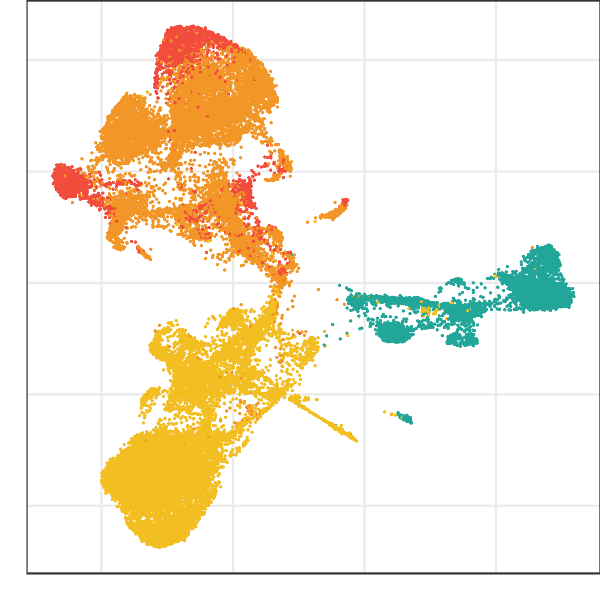

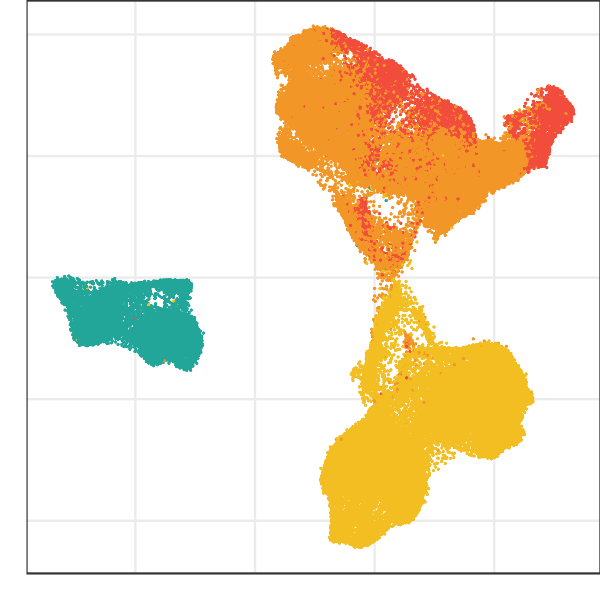

In [17]:
options(repr.plot.width = 5, repr.plot.height = 5)
timepoint_plots <- map(
    df_list,
    function(umap_df) {
        ggplot() +
          geom_point_rast(
              data = umap_df,
              aes(x = UMAP_1,
                  y = UMAP_2,
                  color = timepoint_color),
              size = 0.05
          ) +
          scale_x_continuous("") +
          scale_y_continuous("") +
          scale_color_identity() +
          theme_bw() +
          theme(axis.text = element_blank(),
                axis.ticks = element_blank(),
                panel.grid.minor = element_blank(),
                plot.margin = margin(0,0,0,0))
        }
)
timepoint_plots

$cd8

$cd4


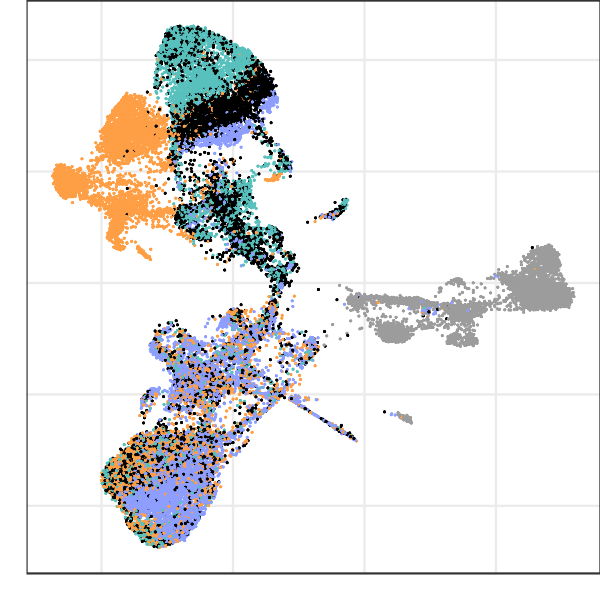

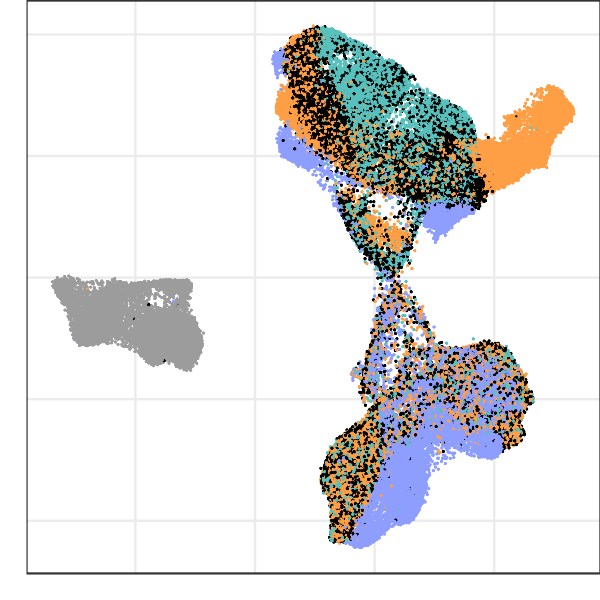

In [18]:
options(repr.plot.width = 5, repr.plot.height = 5)
treatment_plots <- map(
    df_list,
    function(umap_df) {
        ggplot() +
          geom_point_rast(
              data = umap_df,
              aes(x = UMAP_1,
                  y = UMAP_2,
                  color = treatment_color),
              size = 0.05
          ) +
          scale_x_continuous("") +
          scale_y_continuous("") +
          scale_color_identity() +
          theme_bw() +
          theme(axis.text = element_blank(),
                axis.ticks = element_blank(),
                panel.grid.minor = element_blank(),
                plot.margin = margin(0,0,0,0))
        }
)
treatment_plots

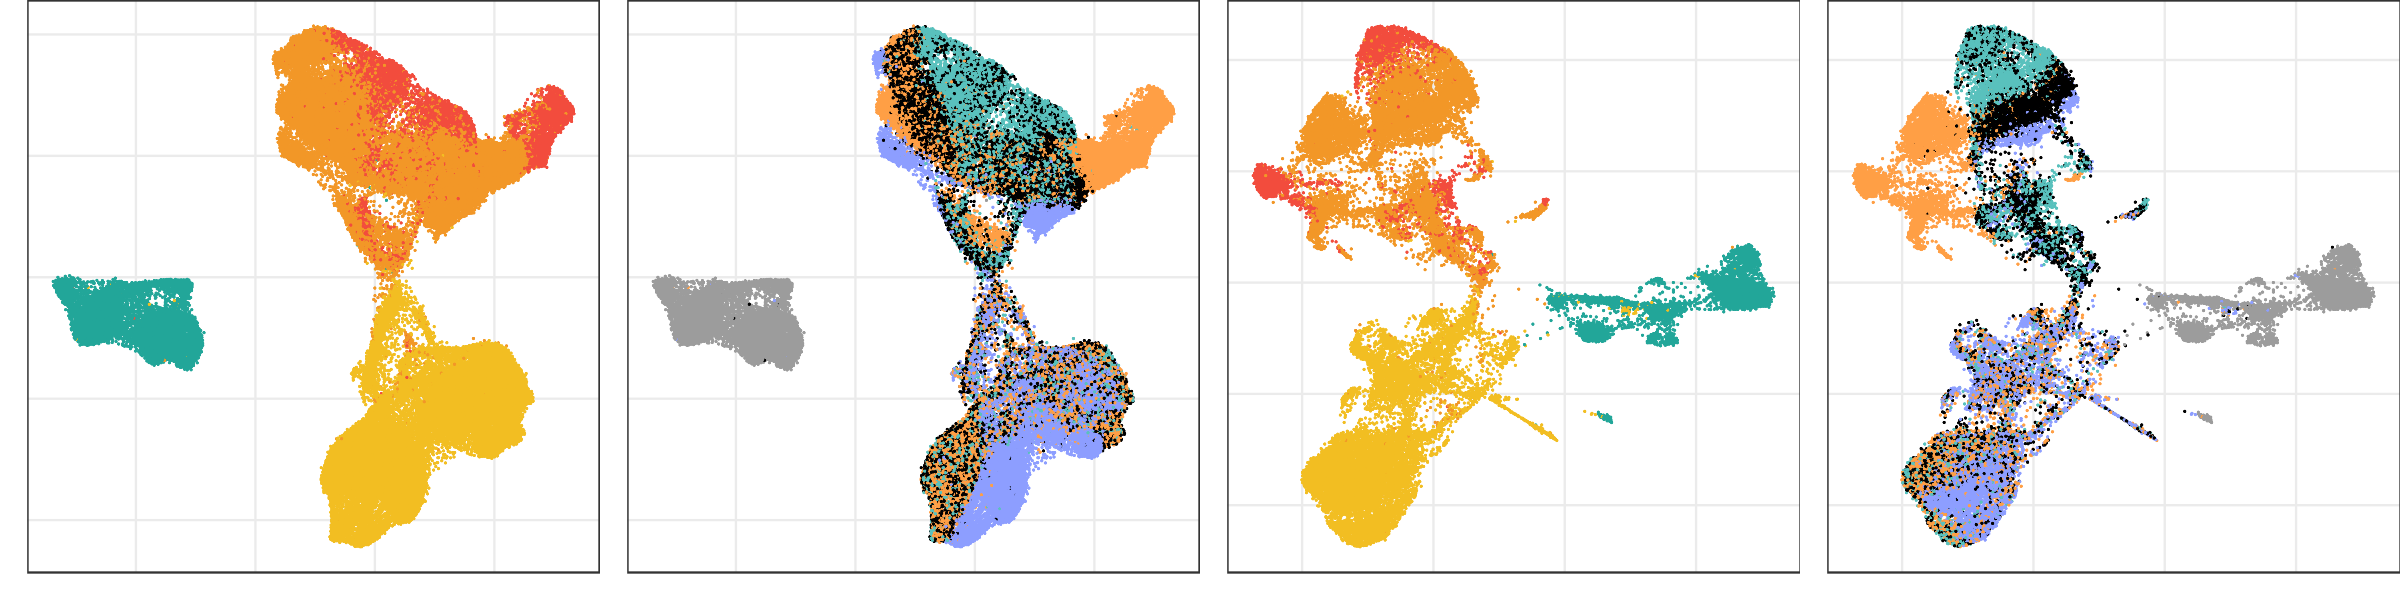

In [19]:
options(repr.plot.width = 20, repr.plot.height = 5)

all_plots <- plot_grid(
    timepoint_plots$cd4, treatment_plots$cd4,
    timepoint_plots$cd8, treatment_plots$cd8,
    ncol = 4,
    nrow = 1,
    align = "h",
    axis = "tb"
)

all_plots

In [20]:
umap_plot_file <- file.path(out_dir, paste0("class_non-integ_umaps_", Sys.Date(), ".pdf"))
ggsave(
    umap_plot_file,
    all_plots,
    width = 20, height = 5
)

## Perform integration

Next, we'll sample cells and run integration using the same methods in the cell type labeling notebook.

In [21]:
sample_cells <- list(cd4 = 2000, cd8 = 600)

split_list <- map2(
    so_list, sample_cells[names(so_list)],
    function(full_so, n_sample) {
        full_so$treat_time <- paste0(full_so$treatment, "_", full_so$timepoint)
        
        split_so <- map(
            unique(full_so$treat_time),
            function(tt) {
                set.seed(3030)
                
                sel_so <- full_so[,full_so$treat_time == tt]
                sel_so[,sample(1:ncol(sel_so), n_sample)]
                
            }
        )
        split_so
    }
)

In [22]:
integ_list <- map(
    split_list,
    function(split_so) {
        message("normalizing and finding variable features")
        split_so <- map(
            split_so,
            function(so) {
                DefaultAssay(so) <- "RNA"
                
                so <- NormalizeData(so)
                so <- suppressWarnings(FindVariableFeatures(so, nfeatures = 5000))
                
                so
            }
        )
        
        message("finding anchors")
        split_anchors <- FindIntegrationAnchors(
            object.list = split_so, 
            dims = 1:30,
            verbose = FALSE
        )
        
        message("integrating samples")
        integ_so <- IntegrateData(
            anchorset = split_anchors, 
            dims = 1:30,
            verbose = FALSE
        )
        
        integ_so
        
    }
)

normalizing and finding variable features

finding anchors

integrating samples

normalizing and finding variable features

finding anchors

integrating samples



Run UMAP and clustering with integrated datasets

In [23]:
integ_list <- map(
    integ_list,
    function(integ_so) {
        DefaultAssay(integ_so) <- "integrated"
        
        integ_so <- ScaleData(integ_so)
        integ_so <- RunPCA(integ_so, verbose = FALSE)
        
        integ_so <- FindNeighbors(integ_so, dims = 1:30, verbose = FALSE)
        integ_so <- FindClusters(integ_so, verbose = FALSE)
        
        integ_so <- RunUMAP(integ_so, dims = 1:30, verbose = FALSE)
        
        integ_so
    }
)

Centering and scaling data matrix

Centering and scaling data matrix



### Plot integrated treatments and timepoints

In [24]:
names(integ_list[[1]]@meta.data)

[1] "orig.ident"             "nCount_RNA"             "nFeature_RNA"          
 [4] "barcodes"               "adt_umis"               "batch_id"              
 [7] "pool_id"                "chip_id"                "well_id"               
[10] "pbmc_sample_id"         "treatment"              "timepoint"             
[13] "n_reads"                "n_umis"                 "n_genes"               
[16] "n_mito_umis"            "frac_mito_umis"         "original_barcodes"     
[19] "hto_barcode"            "hto_category"           "Sample"                
[22] "archr_name"             "n_fragments"            "n_unique"              
[25] "n_mito"                 "frac_mito"              "RNA_snn_res.0.8"       
[28] "nCount_ADT"             "nFeature_ADT"           "treat_time"            
[31] "CD4pos"                 "CD8pos"                 "CD4_CD8"               
[34] "integrated_snn_res.0.8" "seurat_clusters"

In [25]:
df_list <- map(
    integ_list,
    function(so) {
        umap_df <- as.data.frame(so@reductions$umap@cell.embeddings)
        names(umap_df) <- c("UMAP_1", "UMAP_2")
        umap_df$barcodes <- rownames(umap_df)
        rownames(umap_df) <- NULL

        umap_df <- umap_df %>%
          left_join(so@meta.data) %>%
          left_join(all_labels) %>%
          left_join(type_colors) %>%
          select(barcodes, treatment, timepoint, 
                 seurat_clusters, 
                 aifi_cell_type, cell_type_label, cell_type_color,
                 UMAP_1, UMAP_2) %>%
          left_join(treat_colors) %>%
          left_join(timepoint_colors)
        
        umap_df
    }
)

Joining with `by = join_by(barcodes)`
Joining with `by = join_by(barcodes, treatment, timepoint)`
Joining with `by = join_by(aifi_cell_type)`
Joining with `by = join_by(treatment)`
Joining with `by = join_by(timepoint)`
Joining with `by = join_by(barcodes)`
Joining with `by = join_by(barcodes, treatment, timepoint)`
Joining with `by = join_by(aifi_cell_type)`
Joining with `by = join_by(treatment)`
Joining with `by = join_by(timepoint)`


In [26]:
integ_data_files <- file.path(out_dir, paste0(names(df_list),"_class_integ_umap_data_", Sys.Date(), ".csv"))

walk2(
    df_list,
    integ_data_files,
    write.csv,
    quote = FALSE,
    row.names = FALSE
)

In [27]:
df_list <- map(
    df_list,
    function(umap_df) {
        umap_df[sample(1:nrow(umap_df), nrow(umap_df)),]
    }
)

$cd8

$cd4


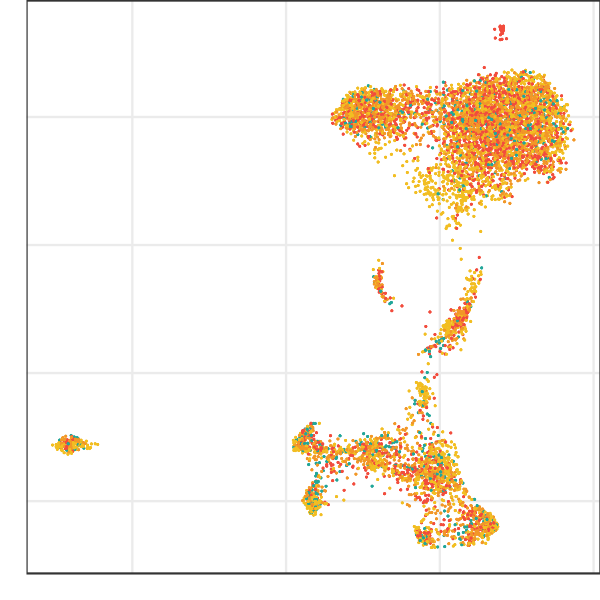

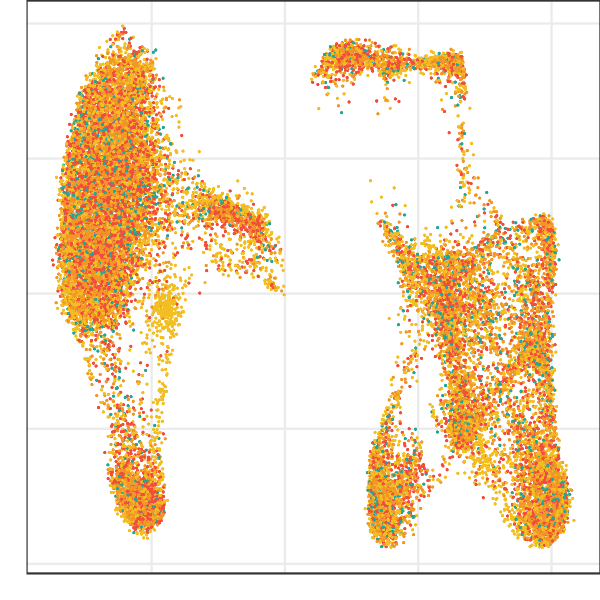

In [28]:
options(repr.plot.width = 5, repr.plot.height = 5)
timepoint_plots <- map(
    df_list,
    function(umap_df) {
        ggplot() +
          geom_point_rast(
              data = umap_df,
              aes(x = UMAP_1,
                  y = UMAP_2,
                  color = timepoint_color),
              size = 0.05
          ) +
          scale_x_continuous("") +
          scale_y_continuous("") +
          scale_color_identity() +
          theme_bw() +
          theme(axis.text = element_blank(),
                axis.ticks = element_blank(),
                panel.grid.minor = element_blank(),
                plot.margin = margin(0,0,0,0))
        }
)
timepoint_plots

$cd8

$cd4


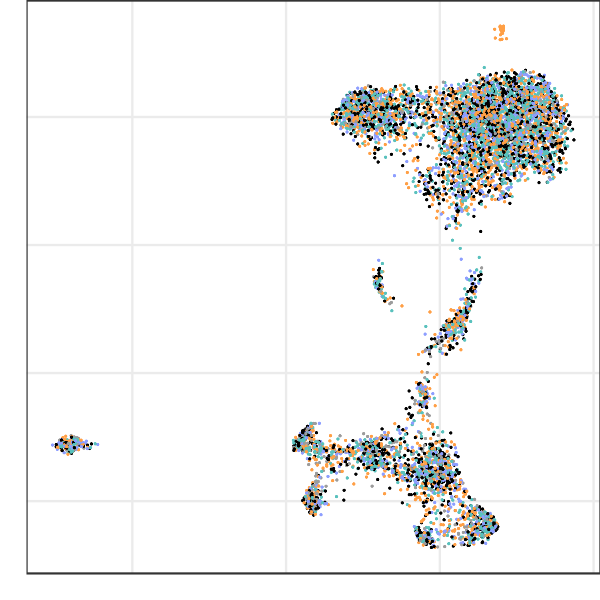

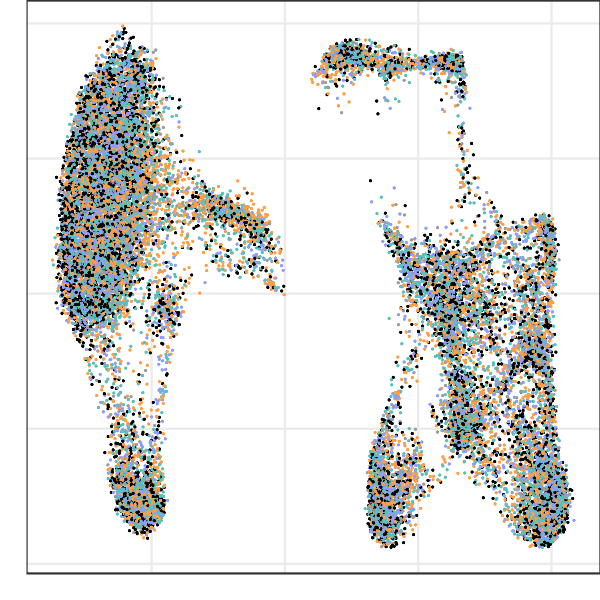

In [29]:
options(repr.plot.width = 5, repr.plot.height = 5)
treatment_plots <- map(
    df_list,
    function(umap_df) {
        ggplot() +
          geom_point_rast(
              data = umap_df,
              aes(x = UMAP_1,
                  y = UMAP_2,
                  color = treatment_color),
              size = 0.05
          ) +
          scale_x_continuous("") +
          scale_y_continuous("") +
          scale_color_identity() +
          theme_bw() +
          theme(axis.text = element_blank(),
                axis.ticks = element_blank(),
                panel.grid.minor = element_blank(),
                plot.margin = margin(0,0,0,0))
        }
)
treatment_plots

$cd8

$cd4


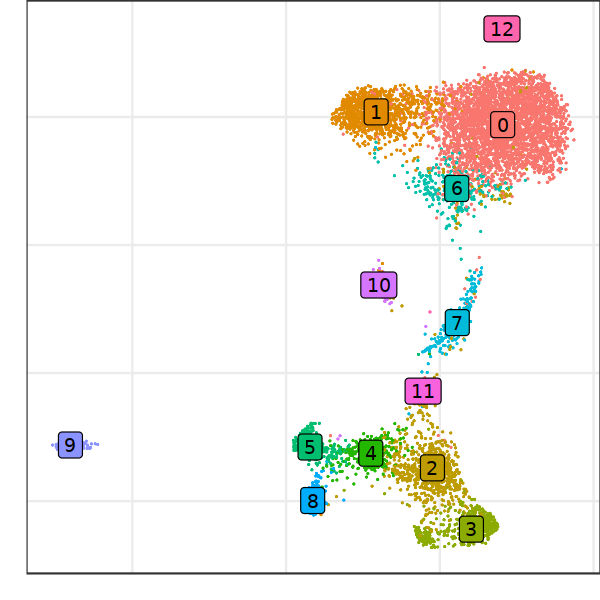

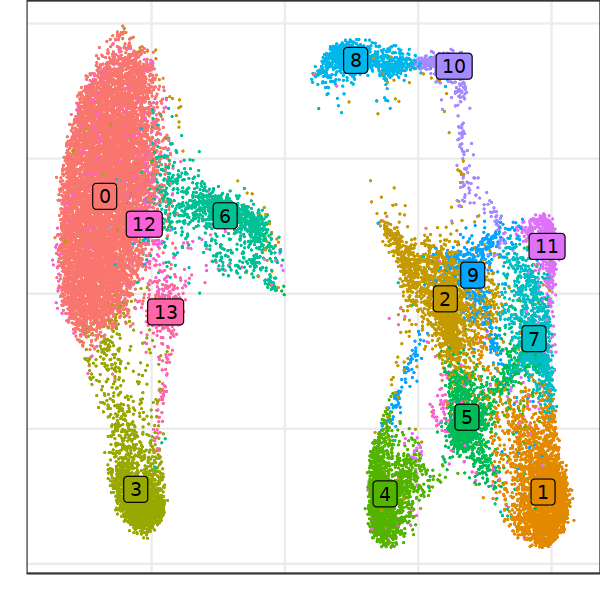

In [30]:
options(repr.plot.width = 5, repr.plot.height = 5)
cluster_plots <- map(
    df_list,
    function(umap_df) {
        label_df <- umap_df %>%
          group_by(seurat_clusters) %>%
          summarise(UMAP_1 = median(UMAP_1),
                    UMAP_2 = median(UMAP_2),
                    .groups = "keep")
        
        ggplot() +
          geom_point_rast(
              data = umap_df,
              aes(x = UMAP_1,
                  y = UMAP_2,
                  color = seurat_clusters),
              size = 0.05
          ) +
          geom_label(
              data = label_df,
              aes(x = UMAP_1,
                  y = UMAP_2,
                  label = seurat_clusters,
                  fill = seurat_clusters)
          ) +
          scale_x_continuous("") +
          scale_y_continuous("") +
          theme_bw() +
          theme(axis.text = element_blank(),
                axis.ticks = element_blank(),
                panel.grid.minor = element_blank(),
                plot.margin = margin(0,0,0,0),
                legend.position = "none")
        }
)
cluster_plots

$cd8

$cd4


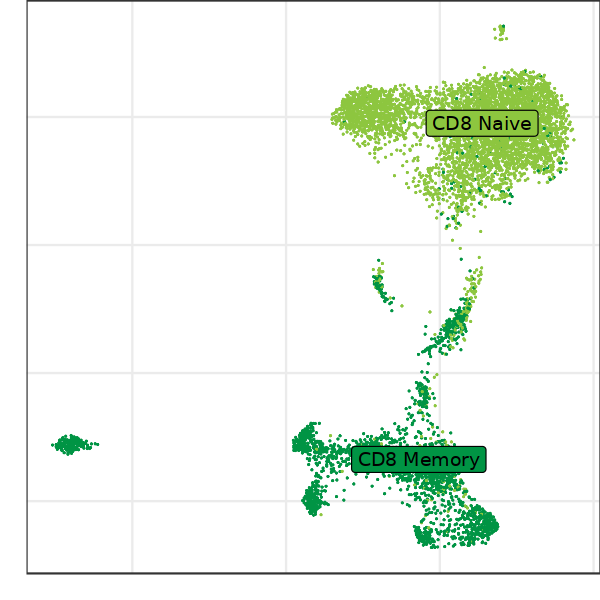

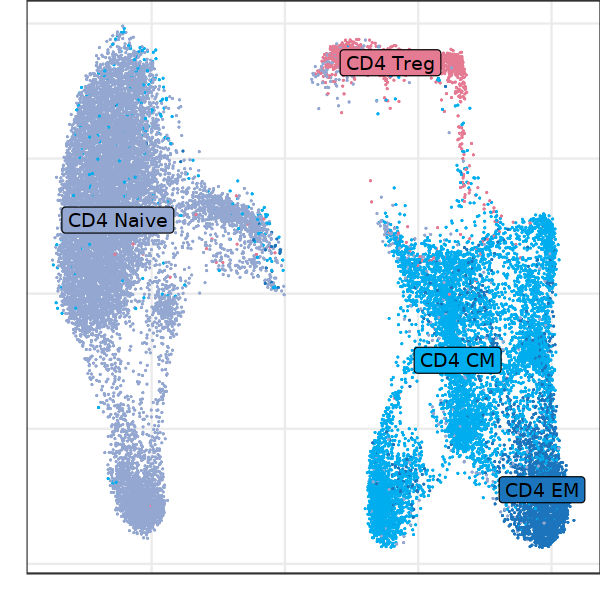

In [31]:
options(repr.plot.width = 5, repr.plot.height = 5)
type_plots <- map(
    df_list,
    function(umap_df) {
        label_df <- umap_df %>%
          group_by(aifi_cell_type, cell_type_label, cell_type_color) %>%
          summarise(UMAP_1 = median(UMAP_1),
                    UMAP_2 = median(UMAP_2),
                    .groups = "keep")
        
        ggplot() +
          geom_point_rast(
              data = umap_df,
              aes(x = UMAP_1,
                  y = UMAP_2,
                  color = cell_type_color),
              size = 0.05
          ) +
          geom_label(
              data = label_df,
              aes(x = UMAP_1,
                  y = UMAP_2,
                  label = cell_type_label,
                  fill = cell_type_color)
          ) +
          scale_x_continuous("") +
          scale_y_continuous("") +
          scale_color_identity() +
          scale_fill_identity() +
          theme_bw() +
          theme(axis.text = element_blank(),
                axis.ticks = element_blank(),
                panel.grid.minor = element_blank(),
                plot.margin = margin(0,0,0,0))
        }
)
type_plots

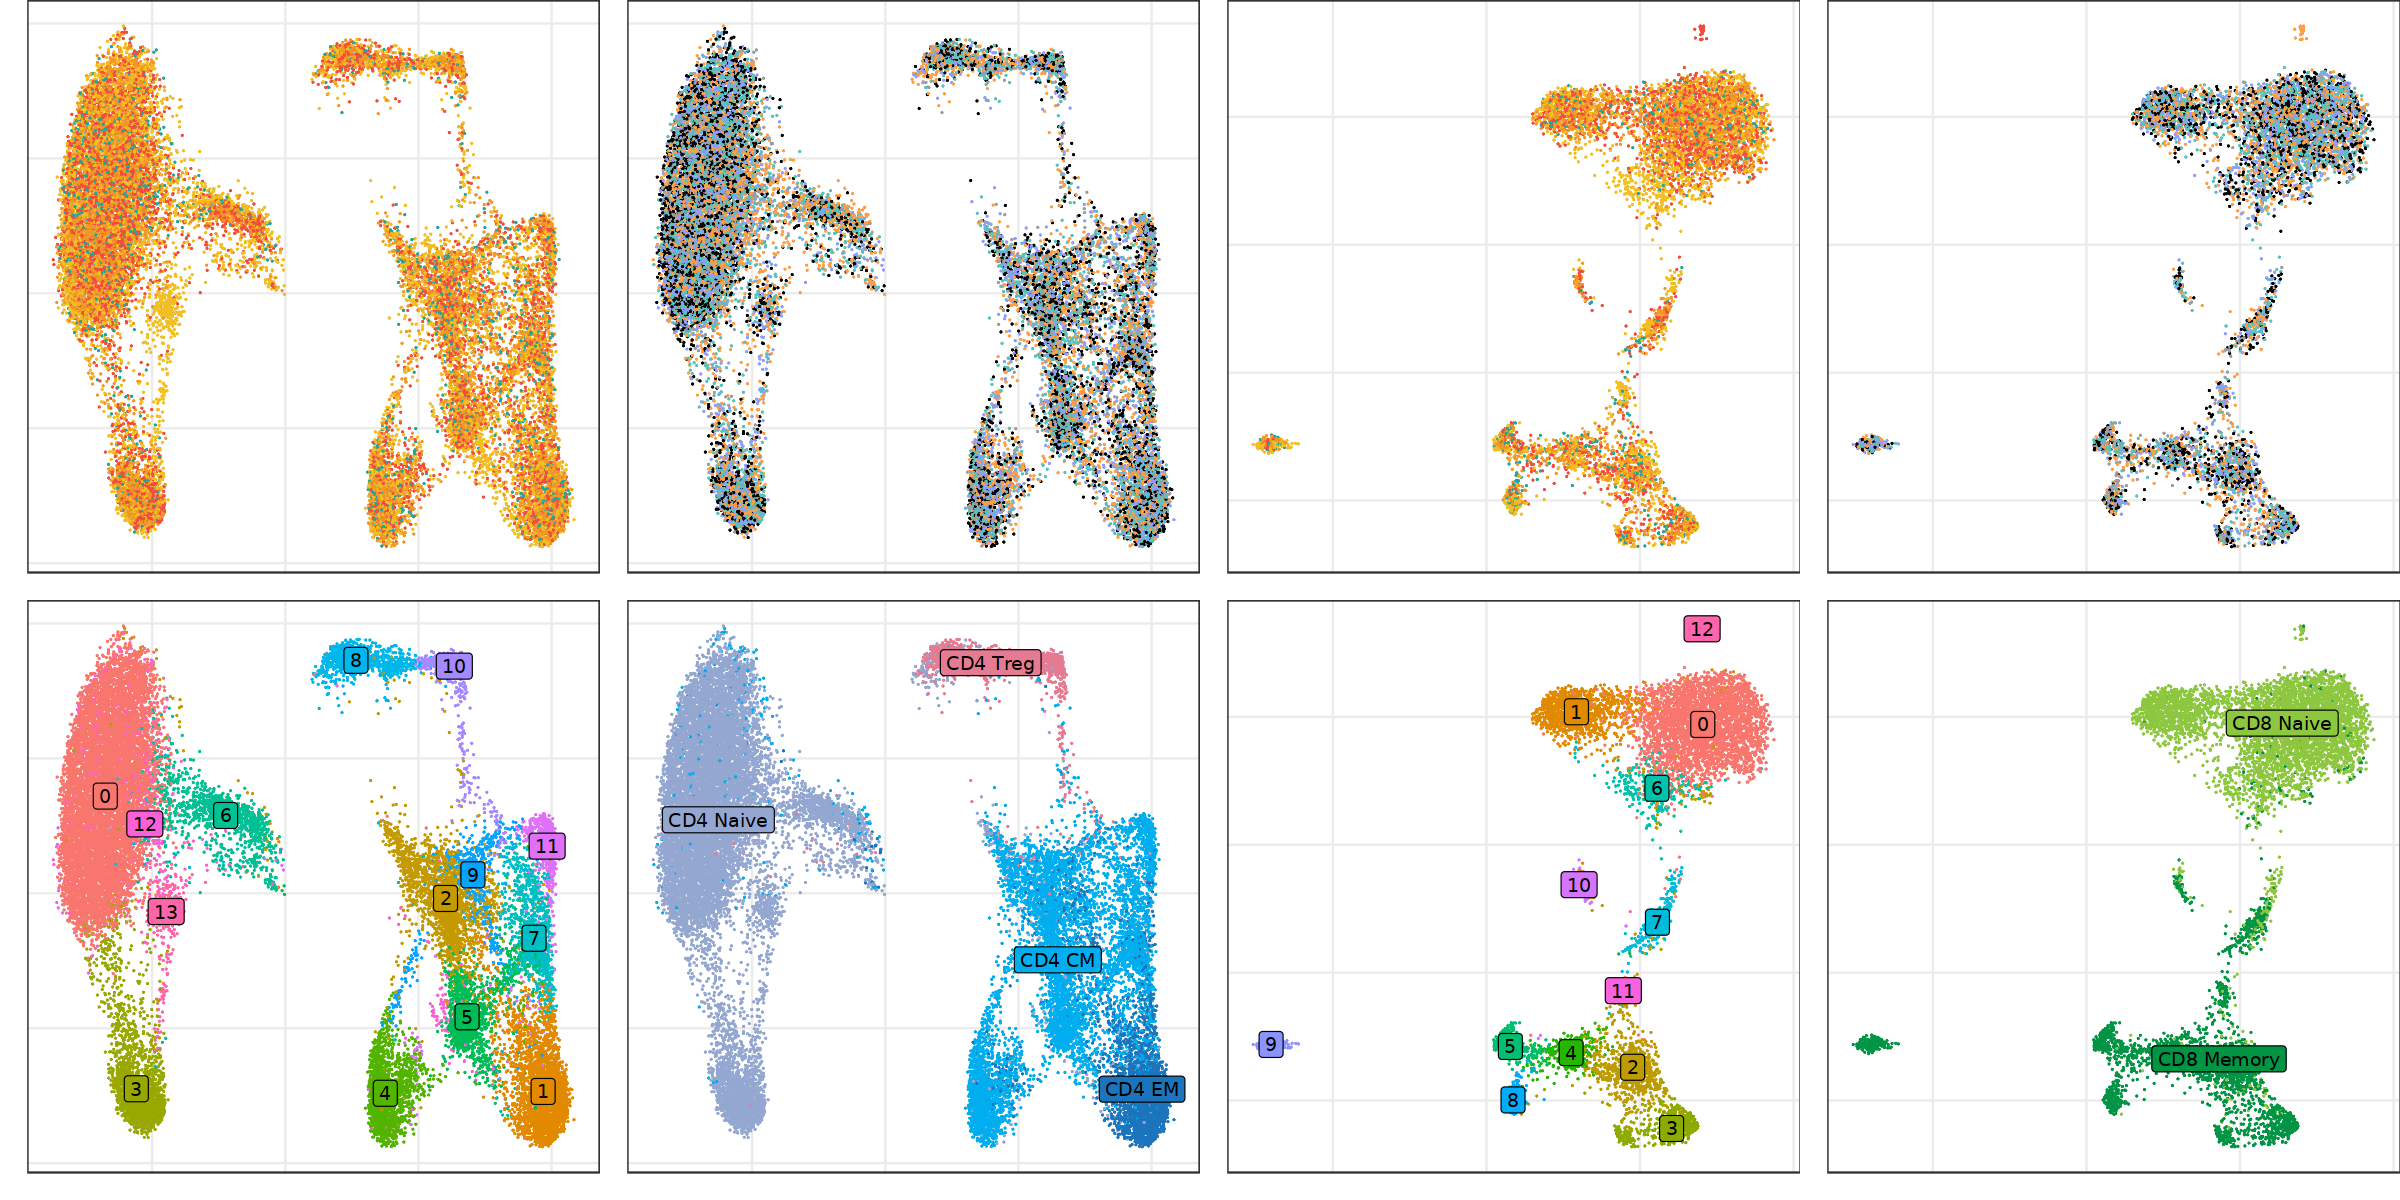

In [32]:
options(repr.plot.width = 20, repr.plot.height = 10)

all_plots <- plot_grid(
    timepoint_plots$cd4, treatment_plots$cd4, timepoint_plots$cd8, treatment_plots$cd8,
    cluster_plots$cd4, type_plots$cd4, cluster_plots$cd8, type_plots$cd8,
    ncol = 4,
    nrow = 2,
    align = "h",
    axis = "tb"
)

all_plots

In [33]:
integ_plot_file <- file.path(out_dir, paste0("class_integ_umaps_", Sys.Date(), ".pdf"))
ggsave(
    integ_plot_file,
    all_plots,
    width = 20, height = 10
)

## Marker expression figures

In [34]:
summarize_mat <- function(mat) {
    mat <- Matrix::Matrix(mat, sparse = TRUE)
    
    tmat <- Matrix::t(mat)
    
    zero_idx <- colSums(tmat) == 0
    zero_genes <- colnames(tmat)[zero_idx]
    tmat <- tmat[,!zero_idx]
    
    res = data.frame(
        gene = colnames(tmat),
        n_cells = nrow(tmat),
        n_nonzero = diff(tmat@p),
        frac_nonzero = diff(tmat@p) / nrow(tmat),
        sum = colSums(tmat),
        mean = colMeans(tmat),
        mean_nonzero = map_dbl(split(tmat@x, rep(1:ncol(tmat), diff(tmat@p))), mean)
    )
    
    if(length(zero_genes) > 0) {
        z_res = data.frame(
            gene = zero_genes,
            n_cells = nrow(tmat),
            n_nonzero = 0,
            frac_nonzero = 0,
            sum = 0,
            mean = 0,
            mean_nonzero = 0)
        res <- rbind(res, z_res)
    }
    
    res <- res[match(res$gene, rownames(mat)),]
    rownames(res) <- NULL
    
    res
}

### CD4 Markers

In [35]:
cd4_rna_markers <- c("UBE2E2", "MAF", "CCL5", "FOXP3")

In [36]:
cd4_so <- integ_list[["cd4"]]

In [37]:
cluster_labels <- cd4_so@meta.data %>%
  left_join(all_labels) %>%
  group_by(seurat_clusters, aifi_cell_type) %>%
  summarise(n_type = n(), .groups = "keep") %>%
  arrange(desc(n_type)) %>%
  group_by(seurat_clusters) %>%
  slice(1)

Joining with `by = join_by(barcodes, treatment, timepoint)`


In [38]:
cluster_meta_list <- split(cd4_so@meta.data, cd4_so@meta.data$seurat_clusters)

In [39]:
cluster_rna_mats <- map(
    cluster_meta_list,
    function(meta) {
        cd4_so[["RNA"]]@data[cd4_rna_markers, meta$barcodes]
    }
)

In [40]:
cd4_rna_summary <- map2_dfr(
    cluster_rna_mats, names(cluster_rna_mats),
    function(mat, cl) {
        df <- summarize_mat(mat)
        df$seurat_clusters <- cl
        df
    }
)

In [41]:
cd4_rna_summary$feature <- paste0("rna_", cd4_rna_summary$gene)

In [42]:
cd4_adt_markers <- c("CD45RA", "CD45RO", "CD69", "CD11c", "CD25", "TIGIT")

In [43]:
cluster_adt_mats <- map(
    cluster_meta_list,
    function(meta) {
        cd4_so[["ADT"]]@data[cd4_adt_markers, meta$barcodes]
    }
)

In [44]:
cd4_adt_summary <- map2_dfr(
    cluster_adt_mats, names(cluster_adt_mats),
    function(mat, cl) {
        df <- summarize_mat(mat)
        df$seurat_clusters <- cl
        df
    }
)

In [45]:
cd4_adt_summary$feature <- paste0("adt_", cd4_adt_summary$gene)

In [46]:
cd4_feature_pos <- data.frame(
    feature = c(paste0("adt_", cd4_adt_markers),
                paste0("rna_", cd4_rna_markers)),
    feature_name = c(cd4_adt_markers,
                     cd4_rna_markers)) %>%
  mutate(xpos = 1:n()) %>%
  mutate(xpos = ifelse(grepl("rna_", feature), xpos + 0.5, xpos))

In [47]:
cd4_cluster_pos <- cluster_labels %>%
  ungroup() %>%
  left_join(type_colors) %>%
  arrange(cell_type_ypos, desc(seurat_clusters)) %>%
  mutate(ypos = 1:n(),
         color = rev(scales::hue_pal()(n())))

Joining with `by = join_by(aifi_cell_type)`


In [48]:
plot_df <- rbind(cd4_adt_summary, cd4_rna_summary) %>%
  left_join(cd4_feature_pos) %>%
  left_join(cd4_cluster_pos) %>%
  group_by(feature) %>%
  mutate(scaled_mean = (mean_nonzero - min(mean_nonzero)) / (max(mean_nonzero) - min(mean_nonzero)))

Joining with `by = join_by(feature)`
Joining with `by = join_by(seurat_clusters)`


In [49]:
cd4_marker_data <- file.path(out_dir, paste0("cd4_marker_data_", Sys.Date(), ".csv"))
write.csv(
    plot_df,
    cd4_marker_data,
    quote = FALSE,
    row.names = FALSE
)

In [50]:
hguides <- cd4_cluster_pos %>%
  group_by(aifi_cell_type) %>%
  summarise(ypos = min(ypos) - 0.5) %>%
  filter(ypos > 1)

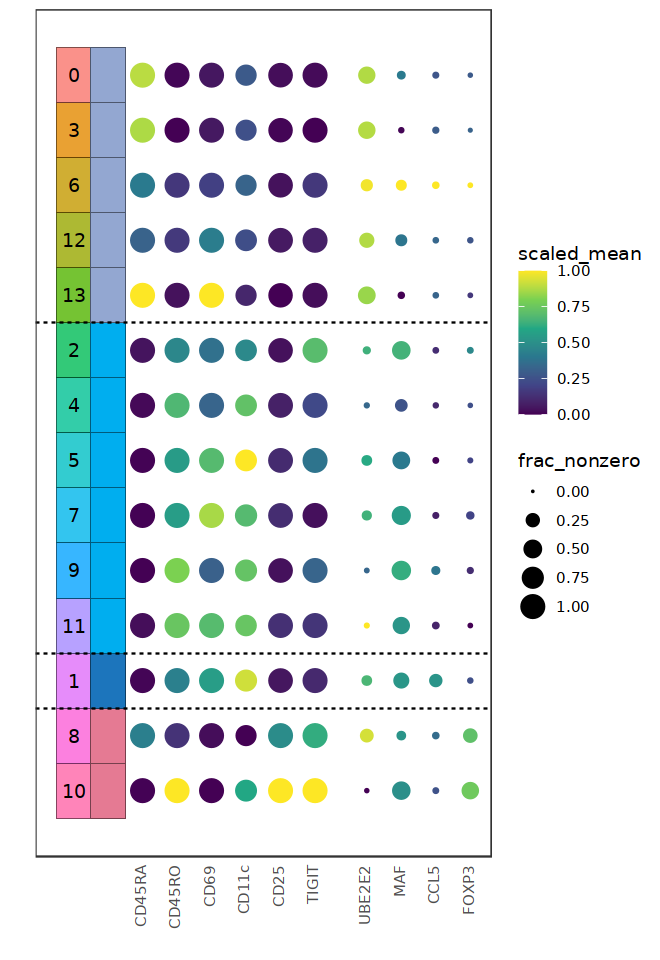

In [51]:
options(repr.plot.width = 5.5, repr.plot.height = 8)

cd4_markers <- ggplot() +
  geom_point(
      data = plot_df,
      aes(x = xpos,
          y = ypos,
          color = scaled_mean,
          size = frac_nonzero)
  ) +
  geom_tile(data = cd4_cluster_pos,
            aes(x = -1,
                y = ypos,
                fill = color),
            color = "black",
            alpha = 0.8) +
  geom_text(data = cd4_cluster_pos,
            aes(x = -1,
                y = ypos,
                label = seurat_clusters)) +
  geom_tile(data = cd4_cluster_pos,
            aes(x = 0,
                y = ypos,
                fill = cell_type_color),
            color = "black") +
  geom_hline(
      data = hguides,
      aes(yintercept = ypos),
      linewidth = 0.5,
      linetype = "dashed"
  ) +
  scale_color_viridis_c() +
  scale_fill_identity() +
  scale_size_area(limits = c(0,1)) +
  scale_x_continuous(
      "",
      breaks = cd4_feature_pos$xpos,
      labels = cd4_feature_pos$feature_name
  ) +
  scale_y_continuous(
      "",
      breaks = cd4_cluster_pos$ypos,
      labels = cd4_cluster_pos$seurat_clusters
  ) +
  theme_bw() +
  theme(panel.grid = element_blank(),
        axis.ticks = element_blank(),
        axis.text.y = element_blank(),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))
cd4_markers

In [52]:
cd4_marker_plot <- file.path(out_dir, paste0("cd4_marker_plot_", Sys.Date(), ".pdf"))
ggsave(
    cd4_marker_plot,
    cd4_markers,
    width = 5.5, height = 8
)

### CD8 Markers

In [53]:
cd8_rna_markers <- c("UBE2E2", "NIBAN1", "CCL5")

In [54]:
cd8_so <- integ_list[["cd8"]]

In [55]:
cluster_labels <- cd8_so@meta.data %>%
  left_join(all_labels) %>%
  group_by(seurat_clusters, aifi_cell_type) %>%
  summarise(n_type = n(), .groups = "keep") %>%
  arrange(desc(n_type)) %>%
  group_by(seurat_clusters) %>%
  slice(1)

Joining with `by = join_by(barcodes, treatment, timepoint)`


In [56]:
cluster_meta_list <- split(cd8_so@meta.data, cd8_so@meta.data$seurat_clusters)

In [57]:
cluster_rna_mats <- map(
    cluster_meta_list,
    function(meta) {
        cd8_so[["RNA"]]@data[cd8_rna_markers, meta$barcodes]
    }
)

In [58]:
cd8_rna_summary <- map2_dfr(
    cluster_rna_mats, names(cluster_rna_mats),
    function(mat, cl) {
        df <- summarize_mat(mat)
        df$seurat_clusters <- cl
        df
    }
)

In [59]:
cd8_rna_summary$feature <- paste0("rna_", cd8_rna_summary$gene)

In [60]:
cd8_adt_markers <- c("CD45RA", "CD45RO", "CD49d", "TCR.Va7.2")

In [61]:
cluster_adt_mats <- map(
    cluster_meta_list,
    function(meta) {
        cd8_so[["ADT"]]@data[cd8_adt_markers, meta$barcodes]
    }
)

In [62]:
cd8_adt_summary <- map2_dfr(
    cluster_adt_mats, names(cluster_adt_mats),
    function(mat, cl) {
        df <- summarize_mat(mat)
        df$seurat_clusters <- cl
        df
    }
)

In [63]:
cd8_adt_summary$feature <- paste0("adt_", cd8_adt_summary$gene)

In [64]:
cd8_feature_pos <- data.frame(
    feature = c(paste0("adt_", cd8_adt_markers),
                paste0("rna_", cd8_rna_markers)),
    feature_name = c(cd8_adt_markers,
                     cd8_rna_markers)) %>%
  mutate(xpos = 1:n()) %>%
  mutate(xpos = ifelse(grepl("rna_", feature), xpos + 0.5, xpos))

In [65]:
cd8_cluster_pos <- cluster_labels %>%
  ungroup() %>%
  left_join(type_colors) %>%
  arrange(cell_type_ypos, desc(seurat_clusters)) %>%
  mutate(ypos = 1:n(),
         color = rev(scales::hue_pal()(n())))

Joining with `by = join_by(aifi_cell_type)`


In [66]:
plot_df <- rbind(cd8_adt_summary, cd8_rna_summary) %>%
  left_join(cd8_feature_pos) %>%
  left_join(cd8_cluster_pos) %>%
  group_by(feature) %>%
  mutate(scaled_mean = (mean_nonzero - min(mean_nonzero)) / (max(mean_nonzero) - min(mean_nonzero)))

Joining with `by = join_by(feature)`
Joining with `by = join_by(seurat_clusters)`


In [67]:
cd8_marker_data <- file.path(out_dir, paste0("cd8_marker_data_", Sys.Date(), ".csv"))
write.csv(
    plot_df,
    cd8_marker_data,
    quote = FALSE,
    row.names = FALSE
)

In [68]:
hguides <- cd8_cluster_pos %>%
  group_by(aifi_cell_type) %>%
  summarise(ypos = min(ypos) - 0.5) %>%
  filter(ypos > 1)

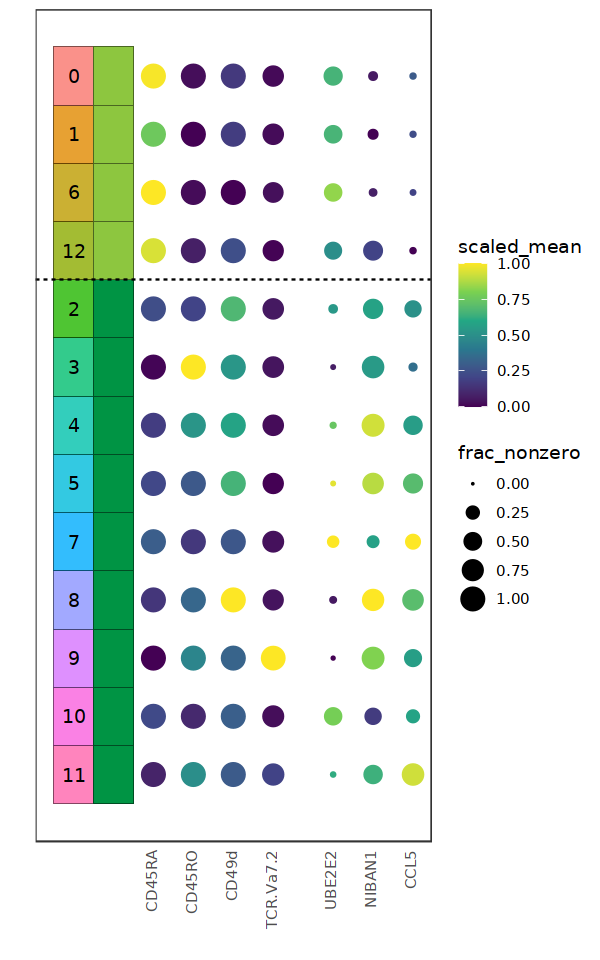

In [69]:
options(repr.plot.width = 5, repr.plot.height = 8)

cd8_markers <- ggplot() +
  geom_point(
      data = plot_df,
      aes(x = xpos,
          y = ypos,
          color = scaled_mean,
          size = frac_nonzero)
  ) +
  geom_tile(data = cd8_cluster_pos,
            aes(x = -1,
                y = ypos,
                fill = color),
            color = "black",
            alpha = 0.8) +
  geom_text(data = cd8_cluster_pos,
            aes(x = -1,
                y = ypos,
                label = seurat_clusters)) +
  geom_tile(data = cd8_cluster_pos,
            aes(x = 0,
                y = ypos,
                fill = cell_type_color),
            color = "black") +
  geom_hline(
      data = hguides,
      aes(yintercept = ypos),
      linewidth = 0.5,
      linetype = "dashed"
  ) +
  scale_color_viridis_c() +
  scale_fill_identity() +
  scale_size_area(limits = c(0,1)) +
  scale_x_continuous(
      "",
      breaks = cd8_feature_pos$xpos,
      labels = cd8_feature_pos$feature_name
  ) +
  scale_y_continuous(
      "",
      breaks = cd8_cluster_pos$ypos,
      labels = cd8_cluster_pos$seurat_clusters
  ) +
  theme_bw() +
  theme(panel.grid = element_blank(),
        axis.ticks = element_blank(),
        axis.text.y = element_blank(),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))
cd8_markers

In [70]:
cd8_marker_plot <- file.path(out_dir, paste0("cd8_marker_plot_", Sys.Date(), ".pdf"))
ggsave(
    cd8_marker_plot,
    cd8_markers,
    width = 5, height = 8
)

## Type label comparison heatmaps

### CD4

In [71]:
cd4_meta <- cd4_so@meta.data

In [72]:
names(all_labels)

[1] "barcodes"                    "treatment"                  
 [3] "timepoint"                   "predicted.celltype.l1.score"
 [5] "predicted.celltype.l1"       "predicted.celltype.l2.score"
 [7] "predicted.celltype.l2"       "predicted.celltype.l3.score"
 [9] "predicted.celltype.l3"       "aifi_cell_type"

In [73]:
cd4_keep_labels <- c("CD4 Naive", "CD4 TCM", "CD4 TEM", "Treg")

cd4_type_frac <- cd4_meta %>%
  left_join(all_labels) %>%
  group_by(seurat_clusters) %>%
  mutate(n_cl = n()) %>%
  group_by(seurat_clusters, predicted.celltype.l2) %>%
  summarise(n_cl = n_cl[1],
            n_seurat = n(),
            .groups = "keep") %>%
  mutate(frac_cl = n_seurat / n_cl) %>%
  filter(predicted.celltype.l2 %in% cd4_keep_labels)

Joining with `by = join_by(barcodes, treatment, timepoint)`


In [74]:
cd4_label_plot_df <- cd4_type_frac %>%
  left_join(cd4_cluster_pos) %>%
  mutate(predicted.celltype.l2 = factor(predicted.celltype.l2, levels = cd4_keep_labels))

Joining with `by = join_by(seurat_clusters)`


In [75]:
cd4_label_data <- file.path(out_dir, paste0("cd4_label_data_", Sys.Date(), ".csv"))
write.csv(
    cd4_label_plot_df,
    cd4_label_data,
    quote = FALSE,
    row.names = FALSE
)

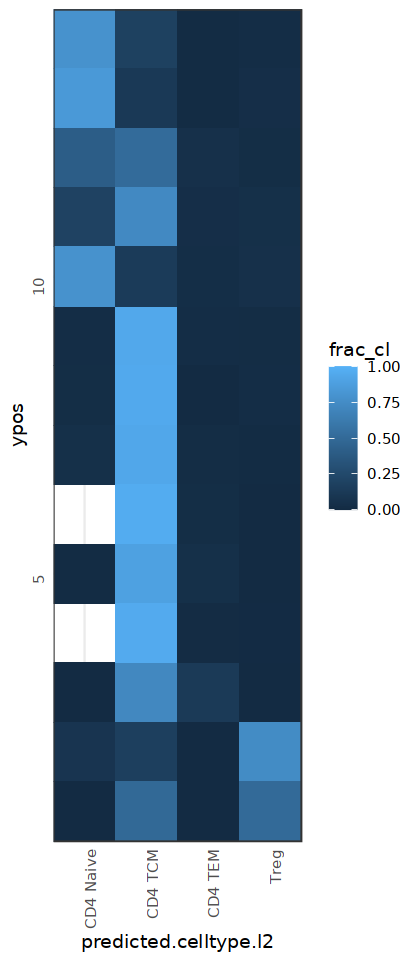

In [76]:
options(repr.plot.width = 3.5, repr.plot.height = 8)
cd4_labels <- ggplot() +
  geom_tile(
      data = cd4_label_plot_df,
      aes(x = predicted.celltype.l2,
          y = ypos,
          fill = frac_cl)
  ) +
  scale_fill_continuous(limits = c(0,1)) +
  scale_x_discrete(expand = c(0,0)) +
  scale_y_continuous(expand = c(0,0)) +
  theme_bw() +
  theme(axis.text = element_text(angle = 90, hjust = 1, vjust = 0.3),
        axis.ticks = element_blank())
cd4_labels

In [77]:
cd4_label_plot <- file.path(out_dir, paste0("cd4_label_plot_", Sys.Date(), ".pdf"))
ggsave(
    cd4_label_plot,
    cd4_labels,
    width = 3.5, height = 8
)

### CD8

In [78]:
cd8_meta <- cd8_so@meta.data

In [79]:
cd8_keep_labels <- c("CD8 Naive", "CD8 TCM", "CD8 TEM")

cd8_type_frac <- cd8_meta %>%
  left_join(all_labels) %>%
  group_by(seurat_clusters) %>%
  mutate(n_cl = n()) %>%
  group_by(seurat_clusters, predicted.celltype.l2) %>%
  summarise(n_cl = n_cl[1],
            n_seurat = n(),
            .groups = "keep") %>%
  mutate(frac_cl = n_seurat / n_cl) %>%
  filter(predicted.celltype.l2 %in% cd8_keep_labels)

Joining with `by = join_by(barcodes, treatment, timepoint)`


In [80]:
cd8_label_plot_df <- cd8_type_frac %>%
  left_join(cd8_cluster_pos) %>%
  mutate(predicted.celltype.l2 = factor(predicted.celltype.l2, levels = cd8_keep_labels))

Joining with `by = join_by(seurat_clusters)`


In [81]:
cd8_label_data <- file.path(out_dir, paste0("cd8_label_data_", Sys.Date(), ".csv"))
write.csv(
    cd8_label_plot_df,
    cd8_label_data,
    quote = FALSE,
    row.names = FALSE
)

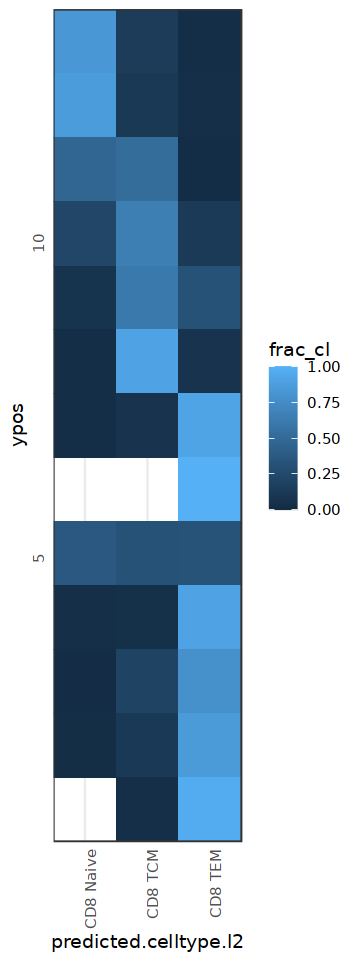

In [82]:
options(repr.plot.width = 3, repr.plot.height = 8)
cd8_labels <- ggplot() +
  geom_tile(
      data = cd8_label_plot_df,
      aes(x = predicted.celltype.l2,
          y = ypos,
          fill = frac_cl)
  ) +
  scale_fill_continuous(limits = c(0,1)) +
  scale_x_discrete(expand = c(0,0)) +
  scale_y_continuous(expand = c(0,0)) +
  theme_bw() +
  theme(axis.text = element_text(angle = 90, hjust = 1, vjust = 0.3),
        axis.ticks = element_blank())
cd8_labels

In [83]:
cd8_label_plot <- file.path(out_dir, paste0("cd8_label_plot_", Sys.Date(), ".pdf"))
ggsave(
    cd8_label_plot,
    cd8_labels,
    width = 3.5, height = 8
)

# Store results in HISE

Finally, we store the output file in our Collaboration Space for later retrieval and use. We need to provide the UUID for our Collaboration Space (aka `studySpaceId`), as well as a title for this step in our analysis process.

The hise function `uploadFiles()` also requires the FileIDs from the original fileset for reference.

In [84]:
study_space_uuid <- "40df6403-29f0-4b45-ab7d-f46d420c422e"
title <- paste("VRd TEA-seq Supp Fig 3 Labeling Plots", Sys.Date())

In [85]:
out_list <- as.list(c(umap_data_files, umap_plot_file, 
                      integ_data_files, integ_plot_file,
                      cd4_marker_data, cd4_marker_plot,
                      cd8_marker_data, cd8_marker_plot,
                      cd4_label_data, cd4_label_plot,
                      cd8_label_data, cd8_label_plot))

In [86]:
out_list

[[1]]
[1] "output/supp_figure_03/cd8_non-integ_umap_data_2023-10-31.csv"

[[2]]
[1] "output/supp_figure_03/cd4_non-integ_umap_data_2023-10-31.csv"

[[3]]
[1] "output/supp_figure_03/class_non-integ_umaps_2023-10-31.pdf"

[[4]]
[1] "output/supp_figure_03/cd8_class_integ_umap_data_2023-10-31.csv"

[[5]]
[1] "output/supp_figure_03/cd4_class_integ_umap_data_2023-10-31.csv"

[[6]]
[1] "output/supp_figure_03/class_integ_umaps_2023-10-31.pdf"

[[7]]
[1] "output/supp_figure_03/cd4_marker_data_2023-10-31.csv"

[[8]]
[1] "output/supp_figure_03/cd4_marker_plot_2023-10-31.pdf"

[[9]]
[1] "output/supp_figure_03/cd8_marker_data_2023-10-31.csv"

[[10]]
[1] "output/supp_figure_03/cd8_marker_plot_2023-10-31.pdf"

[[11]]
[1] "output/supp_figure_03/cd4_label_data_2023-10-31.csv"

[[12]]
[1] "output/supp_figure_03/cd4_label_plot_2023-10-31.pdf"

[[13]]
[1] "output/supp_figure_03/cd8_label_data_2023-10-31.csv"

[[14]]
[1] "output/supp_figure_03/cd8_label_plot_2023-10-31.pdf"

In [87]:
in_list <- c(
    so_uuids, label_uuids
)

In [42]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

Random number generation:
 RNG:     L'Ecuyer-CMRG 
 Normal:  Inversion 
 Sample:  Rejection 
 
locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] uwot_0.1.16                       nabor_0.5.0                      
 [3] BSgenome.Hsapiens.UCSC.hg38_1.4.5 BSgenome_1.68.0                  
 [5] rtracklayer_1.60.1             